<a href="https://colab.research.google.com/github/Qusai23/Amer_ML/blob/master/Final%20Proj%20-%20Covid-19%20Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CSCE 633 HW 5
Team 4: Gabriel Stella, Aaryan Kothapalli, Keishla D. Ortiz-Lopez, Qusai Amer, Yiqing Zhao

# Setup

In [2]:
#only run this if the next cell fails with "module not found" on skfeature
!pip install git+https://github.com/jundongl/scikit-feature.git

  Cloning https://github.com/jundongl/scikit-feature.git to /tmp/pip-req-build-i84h7xir
  Running command git clone -q https://github.com/jundongl/scikit-feature.git /tmp/pip-req-build-i84h7xir
  Created wheel for skfeature: filename=skfeature-1.0.0-cp37-none-any.whl size=61494 sha256=d069faa1f82dd0dca9a70666e95ad24d59347a6c11fff27023a6cc7a4e009a04
  Stored in directory: /tmp/pip-ephem-wheel-cache-z5oo84fo/wheels/5f/b4/c0/c8e13a8fbfaed3dd4b778d6788a3f9044d02b97a820a37f435
Successfully built skfeature


## Imports

In [3]:
#basics
from math import floor, sqrt, pi
from random import sample
import time
import timeit
#helpful progress bar
from tqdm.notebook import tqdm, trange

#file access
import os
import glob
from google.colab import drive

#data processing
import numpy as np
import pandas as pd
import csv
#libraries for image trimming and resizing
from PIL import Image, ImageDraw, ImageFilter

#matplot
%matplotlib inline
import matplotlib.pyplot as plot
plot.rcParams["figure.figsize"] = (20, 10) # (w, h)

#scikit
#gotta love Python and the hard work everybody else put into this stuff
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import accuracy_score, make_scorer
from skimage import io, exposure
from skimage.util import img_as_float
from skimage.color import rgb2gray
from skimage.filters import frangi, meijering, prewitt, gabor
from skimage.feature import hog
from skfeature.function.similarity_based.fisher_score import fisher_score, feature_ranking as rank_fisher
from skfeature.function.statistical_based.gini_index import gini_index, feature_ranking as rank_gini
from skfeature.utility.mutual_information import conditional_entropy
from sklearn.preprocessing import StandardScaler

#torch
import torch
import torch.nn as nn
#tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

#Done
print("Modules loaded")

Modules loaded


## File Loading
Since we are using Colab, we can keep all of our files (e.g., image files, .csv files) in a shared Google Drive folder. The following code sets up the paths for each image folder (raw and preprocessed, train and test) and loads the data files.

In [4]:
#Access to Google Drive content
drive.mount('/content/drive')

#basic directory information
basePath = '/content/drive/My Drive/CSCE633HW5/'
print(os.listdir(basePath))
#directory structure for the project
train_dir_raw = basePath + 'train/'
test_dir_raw = basePath + 'test/'
train_dir = basePath + 'train_PREPROCESSED/' #destination of where images will be saved
test_dir = basePath + 'test_PREPROCESSED/' #destination of where images will be saved
train_dir_cnn = basePath + 'train_CNN/'
test_dir_cnn = basePath + 'test_CNN/'
#data files
train_data = pd.read_csv(basePath + 'train.csv')
test_data = pd.read_csv(basePath + 'test.csv')

#file listing and  loading
def test_extension(f):
  extensions = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG']
  ftitle, fext = os.path.splitext(os.path.basename(f))
  for ext in extensions:
    if(fext == ext):
      return True
  return False
#
def normalize(img):
  return (img - img.mean()) / img.std()
#opens the image file as an skimage
def get_image(directory, f):
  return (img_as_float(io.imread(os.path.join(directory, f))))
#load the images referenced in the given data file
#this ensures they are in the same order
def get_imgs(dataframe,directory):
  imgs = []
  for i in trange(len(dataframe)):
      ig = get_image(directory, dataframe.iloc[i]['filename']) #match the order of the images in the dataframe and train_dir 
      imgs.append(ig)                                            
  return np.array(imgs,dtype='float32')
#get the labels (outcome) as an array 
def get_labels(dataframe):
  labels = dataframe['covid(label)']
  return labels.to_numpy()

Mounted at /content/drive
['train', 'test', 'test_PREPROCESSED', 'train_PREPROCESSED', 'test.csv', 'train.csv', 'adaboost', 'train_CNN', 'improving_performance_copy.pdf', 'improving-performance_copy', 'improving-performance', 'PREPROCESSING.ipynb', 'feature_extraction.ipynb', 'test_CNN', 'Project breakdown.gdoc', 'Result info.gsheet', 'Poster.pptx', 'Poster.pdf', 'bonus.csv', 'bonus.pdf', 'bonus_v2.pdf', 'bonus.ipynb', 'Report.gdoc', 'Poster.gdoc', 'FINAL', 'bonus_v2.csv', 'bonus_final.csv', 'Copy of FINAL']


# Preprocessing
The original images are large in file size and irregularly rectangular.  These images are transformed by batch processing all the train and test images to be uniformly square format with dimensions of 200x200 for feature extraction, visualization, and scoring, and 100x100 for CNN. By preprocessing all the input data, we effectively normalize everything and in turn improve the neural network performance and save processing time by reducing file sizes.

In [5]:
def crop_center(pil_img, crop_width, crop_height): #manual definition of crop_center
    img_width, img_height = pil_img.size
    return pil_img.crop(((img_width - crop_width) // 2,
                         (img_height - crop_height) // 2,
                         (img_width + crop_width) // 2,
                         (img_height + crop_height) // 2))

#Function for getting largest square from center (shaves off excess height, maintain current width)
def crop_max_square(pil_img):
    return crop_center(pil_img, min(pil_img.size), min(pil_img.size))

#function that takes in source folder of images, destination folder to save, and image width
#The for loop reads each image file, converts to RGB, resizes using LANCZOS filter and saves it to dst_dir
def preprocess(src_dir,dst_dir,imageWidth):
  files = [f for f in os.listdir(src_dir) if test_extension(f)]
  print("Processing", src_dir, "->", dst_dir, f"({imageWidth}x{imageWidth})")
  for f in tqdm(files):
    im = Image.open(os.path.join(src_dir, f))
    im = im.convert("RGB") # important, not all are JPEG. Converts from RGBA to JPEG compatible
    im_thumb = crop_max_square(im).resize((imageWidth, imageWidth), Image.LANCZOS)
    im_thumb.save(os.path.join(dst_dir, f), quality=95)
  print("Processed", len(files), "files")


In [6]:
preprocess(train_dir_raw, train_dir, 200)
preprocess(test_dir_raw, test_dir, 200)
preprocess(train_dir_raw, train_dir_cnn, 100)
preprocess(test_dir_raw, test_dir_cnn, 100)

Processing /content/drive/My Drive/CSCE633HW5/train/ -> /content/drive/My Drive/CSCE633HW5/train_PREPROCESSED/ (200x200)



Processed 250 files
Processing /content/drive/My Drive/CSCE633HW5/test/ -> /content/drive/My Drive/CSCE633HW5/test_PREPROCESSED/ (200x200)



Processed 94 files
Processing /content/drive/My Drive/CSCE633HW5/train/ -> /content/drive/My Drive/CSCE633HW5/train_CNN/ (100x100)



Processed 250 files
Processing /content/drive/My Drive/CSCE633HW5/test/ -> /content/drive/My Drive/CSCE633HW5/test_CNN/ (100x100)



Processed 94 files


# Load the training files

In [7]:
#load the datasets
X_train_img = get_imgs(train_data, train_dir)
#X_train = features(X_img_train)
X_train_cnn = get_imgs(train_data, train_dir_cnn)
y_train = get_labels(train_data)



# Feature Extraction and Visualization
We extract the following features:
* Gabor filters (horizontal and vertical): Gabor filters (i.e., filter banks) are a common tool in visual feature extraction kits
* Prewitt edge detector: edge detection is another common ingredient in any visual feature extraction kit. It should especially help highlight the "branches" inside of the lungs.
* HOG: Histogram of Oriented Gradients is a common and powerful feature extractor. Our later feature selection methods found that the HOG features were some of the most valuable.

Each feature can be visualized as an image (result of applying the filter to the input image) and as a histogram (generated from pixel values).

To generate a feature vector, we simply concatenate all features.

In [8]:
X_test = get_imgs(test_data, test_dir_cnn)
X_test[0]

array([[[0.10196079, 0.10196079, 0.10196079],
        [0.10588235, 0.10588235, 0.10588235],
        [0.10196079, 0.10196079, 0.10196079],
        ...,
        [0.12156863, 0.12156863, 0.12156863],
        [0.12941177, 0.12941177, 0.12941177],
        [0.13333334, 0.13333334, 0.13333334]],

       [[0.09411765, 0.09411765, 0.09411765],
        [0.09803922, 0.09803922, 0.09803922],
        [0.09803922, 0.09803922, 0.09803922],
        ...,
        [0.09019608, 0.09019608, 0.09019608],
        [0.08235294, 0.08235294, 0.08235294],
        [0.07843138, 0.07843138, 0.07843138]],

       [[0.09411765, 0.09411765, 0.09411765],
        [0.09803922, 0.09803922, 0.09803922],
        [0.09411765, 0.09411765, 0.09411765],
        ...,
        [0.20784314, 0.20784314, 0.20784314],
        [0.16470589, 0.16470589, 0.16470589],
        [0.13333334, 0.13333334, 0.13333334]],

       ...,

       [[0.42745098, 0.42745098, 0.42745098],
        [0.44313726, 0.44313726, 0.44313726],
        [0.44313726, 0

In [1]:
#prepares n subplot boxes
def npaxes(n):
    #
    r = floor(sqrt(n))
    while(n % r != 0):
        r -= 1
    c = int(n / r)
    #
    fig, ax = plot.subplots(r, c)
    r_ = 0
    c_ = 0

    axes = []

    for _ in range(n):
        if(c == 1 or r == 1):
          axes.append(ax[max(r_, c_)])
        else:
          axes.append(ax[r_, c_])
        #
        c_ += 1
        if(c_ >= c):
            c_ = 0
            r_ += 1

    #plot.tight_layout()
    #plot.show()

    return axes

#I wanted to use meijering neuriteness / frangi edge filters
#but they didn't really work - prewitt filter seemed to extract edges much better

#extracts the following features:
#-two gabor filters
#-prewitt edge filter
#-HOG
#also generates visualization data for each
#so it returns a pair, first element = feature vector, second element = visualization stuff
def extract_features(img):
    img = rgb2gray(img)
    g1 = gabor(img, 1, theta = 0)
    g2 = gabor(img, 1, theta = pi / 2)
    p = prewitt(img)
    (hog_fd, hog_img) = hog(img, visualize=True)
    hog_img = exposure.rescale_intensity(hog_img, in_range=(0, 10))
    #
    #features = [np.histogram(feat, bins='sqrt') for feat in [g1[0], g2[0], p]] + [hog_fd]
    features = np.concatenate((g1[0].flatten(), g2[0].flatten(), p.flatten(), hog_fd))
    visualizations = [img, g1[0], g2[0], p, hog_img]
    labels = ["Src", "Gabor1", "Gabor2", "Prewitt", "HOG"]
    # print(f" Gabor 1 are: {len(g1[0].flatten())}")
    # print(f" Gabor 2 are: {len(g2[0].flatten())}")
    # print(f" prewett are: {len(p.flatten())}")
    # print(f" HOG are: {len(hog_fd)}")

    return (features, (visualizations, labels))

def display_features(vl):
    (vis, labels) = vl
    n = len(vis)
    axes = npaxes(n * 2)
    for i in range(n):
        f = vis[i]
        axes[i].imshow(f, cmap="gray")
        axes[i].set_xlabel(labels[i])
        axes[i + n].hist(f.flatten(), bins="sqrt")
        axes[i + n].set_xlabel(labels[i])

def features(imgs):
    feats = []
    vis = []
    for img in tqdm(imgs, desc="Extracting features"):
        (feat, v) = extract_features(img)
        feats.append(feat)
        vis.append(v)
    return (np.stack(feats), np.stack(vis)) #.array and .stack should do the same thing here, I believ

In [2]:
(X_train, X_train_vis) = features(X_train_img)

#visualize one random point
display_features(X_train_vis[sample(range(X_train_vis.shape[0]), 1)[0]])

NameError: ignored

## Feature Scoring
We use the skfeature package, along with some custom code, to generate three types of scores:
* Fisher score
* Gini index
* Conditional entropy

For each score type, we rank the features, and collect the top ten. We then combine the resulting 30 features into a set (eliminating duplicates) and display a histogram over the distribution of each of the resulting ~30 features. Note that some have an almost-uniform distribution; these were chosen by conditional entropy minimization.

In [14]:
#unfortunately, there isn't any way to add a progress bar to the skfeature methods.
# :(

#conditional entropy
def all_entropies(X, y):
  feats = X.shape[1] #number of features
  entropies = [0] * feats
  for f in trange(feats):
    Xs = X[:,f]
    entropies[f] = conditional_entropy(Xs, y)
  return entropies

#returns the indices of entries in ascending order
def sort_ranks(xs):
  n = len(xs)
  #associate each with its index
  ids = zip(xs, range(n))
  #sort by value and then retrieve index
  return [x[1] for x in sorted(ids, key = lambda t: t[0])]

entropy_scores = all_entropies(X_train, y_train)
entropy_rank = sort_ranks(entropy_scores)
entropy_n = 10
print("Top", entropy_n, "features (entropy):", entropy_rank[:entropy_n])

#fisher score
fisher_scores = fisher_score(X_train, y_train) #score for each feature
fisher_rank = rank_fisher(fisher_scores) #feature indices sorted by fisher score
fisher_n = 10
print("Top", fisher_n, "features (fisher):", fisher_rank[:fisher_n])

#gini index (takes a long time to calculate)
gini_indices = gini_index(X_train, y_train)
gini_rank = rank_gini(gini_indices)
gini_n = 10
print("Top", gini_n, "features (gini):", gini_rank[:gini_n])


Top 10 features (entropy): [80000, 80001, 80002, 80003, 80004, 80005, 80006, 80007, 80008, 80009]
Top 10 features (fisher): [160903 162811 162739 146060 160975 147896 149732 147933  39400  79400]


KeyboardInterrupt: ignored

In [ ]:
#plot histograms of the distribution of each of the most important features

def display_best_features(X, features):
    n = len(features)
    axes = npaxes(n)
    for i in range(n):
        f = features[i]
        data = X[:,f]
        axes[i].set_xlabel("Feature " + str(f))
        axes[i].hist(data, bins="sqrt")

#remove duplicates and sort (makes it back into a list)
def get_best_features():
  a = entropy_rank[:entropy_n]
  b = fisher_rank[:fisher_n].tolist()
  c = gini_rank[:gini_n].tolist()
  return sorted(set(a + b + c))

best_features = get_best_features()
print("Best features:", best_features)
display_best_features(X_train, best_features)

## Feature Selection

As seen in the previous feature extraction section, there were about 162,800s potential features. This large number needs to go through a robust feature selection processes to select the best-performing ones. The two ways that are used for feature selections are:

#### First: the filter method
The filter method uses statistical calculations to rank each feature based on uni-variate metrics such as variance, chi-square, and correlation coefficients. This method is implemented via SelectKbest from scikit-learn library in which the K represents the number of features to be selected. In this particular application, the statistical test used is chi-square and the K value used is set to 50. The output is a feature matrix of the selected ones that can be easily used in any machine learning method. Note that this mehtod took less than a minute to converage.

#### Second: the wrapper method
The wrapper method tests the performance of certian features in a machine learning algorithm and select the best-performing. In this application, the Recursive Feature Elimination (REF) is utilized to select the features; it works by starting with all features and continuously removing the least performing ones until the target number is reached. The machine learning algorithm used to test the features is the logistic regression. Initially, 50 features were specified from the total feature space; however, it would take a considerable about of time to go through all features and apply them to the regression model so as a result two options were investigated. First, specifying a step of 1000 in which will be skipped at each iteration; this option took two hours to converge and its accuracies were lower than the filter method. The other option was using a filter method to get a 1000 feature then applying the wrapper method to those 1000 features to get 50 features; this method only took one minute to coverage with higher accuraices. As a result, the second option is chosen as will be seen below. 

#### Cross-validation via logistic regression
The features resulted from the two selection methods will be further tested in a simple classifier. The machine learning classifier used is logistic regression as it is considered a simple yet powerful classifier. Initially, cross-validation is implemented in which the training data is split into five folds. Then the logistic regression is applied inside the cross-validation algorithm resulting in five accuracies for each fold. For the filter method, the output of the method is used as the feature matrix in the logistic regression model resulting in an average accuracy of 62.4%. Similarly, the wrapper method output is a feature matrix (X_wrapper) that is plugged in the logistic regression model and generates average accuracy of 68.4%.

In [15]:
#Filter Method
#use SelectKbest from sklearn that takes the matrix features, the labels
#and number of features to select (k) then performs statistical tests to
#select k number of features 
#the number of features targeted is 50

skb = SelectKBest(chi2, k=50)
X_filter = skb.fit_transform(X_train, y_train)
print("Filter-method feature indices:", skb.get_support(indices = True)) #this prints the indices of the selected features

#The wrapper method used is the Recursive Feature Elimination (RFE) 
#it works by recursively removing features and building a model on the remaining
#this method would go over all the features (162,000) and as a result takes a lot of time to run
#A way to lower the computational time for the wrapper method is to use 
#the filter method initially and apply it to get 2000 feature out of the 162,000
#then the REF is applied to the 1000 features to select 50 features


#Filter method 
skb2 = SelectKBest(chi2, k=1000)
X_filter2 = skb2.fit_transform(X_train, y_train)
#print(skb2.get_support(indices = True))

#Wrapper method 

model = LogisticRegression(solver='lbfgs', max_iter=10000)
rfe = RFE(model, 50)
X_wrapper2 = rfe.fit_transform(X_filter2, y_train)
print("Wrapper-method feature indices:", skb2.get_support(indices = True)[rfe.get_support(indices = True)]) #this prints the indicies of the selected features

Filter-method feature indices: [37400 37600 37800 38000 38199 38200 38399 38400 38600 38601 38800 38801
 39000 39001 39199 39200 39201 39399 39400 39401 39600 39601 39602 39800
 39801 77400 77600 77800 78000 78199 78200 78399 78400 78600 78601 78800
 78801 79000 79001 79199 79200 79201 79399 79400 79401 79600 79601 79602
 79800 79801]
Wrapper-method feature indices: [    35  21199  21399  26399  34598  34801  36395  38195  38600  38800
  38992  38996  39606  39609  40035  60999  61199  61399  63798  74598
  74801  78600  78800  78992  78996  79399  79609 117286 117296 118290
 118294 146060 147896 147933 149732 151814 153413 153650 155177 155249
 155258 155321 160903 160975 161057 161129 161291 162739 162811 162817]


findfont: Font family ['Comic Sans MS'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Comic Sans MS'] not found. Falling back to DejaVu Sans.


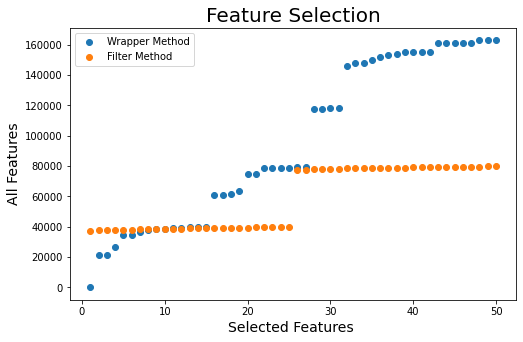

In [16]:
plot.figure(figsize = (8,5))

plot.scatter([i for i in range(1,51)],skb2.get_support(indices = True)[rfe.get_support(indices = True)], label = "Wrapper Method")
plot.scatter([i for i in range(1,51)],skb.get_support(indices = True), label = "Filter Method")
plot.title('Feature Selection', fontdict = {'fontname':'Comic Sans MS','fontsize':20})
plot.xlabel('Selected Features ',fontdict = {'fontsize' : 14, 'fontname':'Comic Sans MS'})
plot.ylabel('All Features',fontdict = {'fontsize' : 14, 'fontname':'Comic Sans MS'})



plot.legend()

In [17]:
#used to test each of the features
def cross_val(X, y, plt):
  random_index = np.random.permutation(len(X))
  scores = []
  for i in range(0,5):
      #initilize the training/testing lists
      Xs = []
      Xt = []
      ys = []
      yt = []
      #split into 5 folds randomly
      for j in range(0,len(X)): 
          if (j%5 ==i):
              Xs.append(X[random_index[j]])
              ys.append(y[random_index[j]])
          else: 
              Xt.append(X[random_index[j]])
              yt.append(y[random_index[j]])
      #convert list to array
      Xs = np.asarray(Xs)
      Xt = np.asarray(Xt)
      ys = np.asarray(ys)
      yt = np.asarray(yt)
      
      #apply logistic regression to the testing data
      model = LogisticRegression(solver='saga', max_iter=10000)
      #C = Inverse of regularization strength; must be a positive float --> smaller values specify stronger regularization.
      model.fit(Xt, yt)
      pred = model.predict(Xs)
      score = model.score(Xs, ys)
      scores += [score]
      print((round(score,3)))


      # plot the performance 
      plot.plot(range(1, len(scores)+1), scores)
      plot.yticks([0,0.2,0.4,0.6,0.8,1])
      plot.xticks([0, 1, 2, 3, 4, 5])
      plot.title(plt, fontsize = 17)
      plot.xlabel("Subset of features", fontsize = 14)
      plot.ylabel("Cross validation score ", fontsize =14)
      # plot.show()
  print("Mean score:", round(sum(scores) / len(scores),3))

In [18]:
#used to test each of the features
random_index = np.random.permutation(len(X_filter))
scores = []
for i in range(0,5):
    #initilize the training/testing lists
    Xs = []
    Xt = []
    ys = []
    yt = []
    #split into 5 folds randomly
    for j in range(0,len(X_filter)): 
        if (j%5 ==i):
            Xs.append(X_filter[random_index[j]])
            ys.append(y_train[random_index[j]])
        else: 
            Xt.append(X_filter[random_index[j]])
            yt.append(y_train[random_index[j]])
    #convert list to array
    Xs = np.asarray(Xs)
    Xt = np.asarray(Xt)
    ys = np.asarray(ys)
    yt = np.asarray(yt)
    
    #apply logistic regression to the testing data
    model = LogisticRegression(solver='saga', max_iter=10000)
    #C = Inverse of regularization strength; must be a positive float --> smaller values specify stronger regularization.
    model.fit(Xt, yt)
    pred = model.predict(Xs)
    score = model.score(Xs, ys)
    scores += [score]
    print((round(score,3)))


    

    #used to test each of the features
random_index = np.random.permutation(len(X_filter))
scores2 = []
for i in range(0,5):
    #initilize the training/testing lists
    Xs = []
    Xt = []
    ys = []
    yt = []
    #split into 5 folds randomly
    for j in range(0,len(X_wrapper2)): 
        if (j%5 ==i):
            Xs.append(X_wrapper2[random_index[j]])
            ys.append(y_train[random_index[j]])
        else: 
            Xt.append(X_wrapper2[random_index[j]])
            yt.append(y_train[random_index[j]])
    #convert list to array
    Xs = np.asarray(Xs)
    Xt = np.asarray(Xt)
    ys = np.asarray(ys)
    yt = np.asarray(yt)
    
    #apply logistic regression to the testing data
    model = LogisticRegression(solver='saga', max_iter=10000)
    #C = Inverse of regularization strength; must be a positive float --> smaller values specify stronger regularization.
    model.fit(Xt, yt)
    pred = model.predict(Xs)
    score = model.score(Xs, ys)
    scores2 += [score]
    print((round(score,3)))


    # plot the performance 
  # plot the performance 
  plot.plot(range(1, len(scores)+1), scores,)
  print("Mean score:", round(sum(scores) / len(scores),3))
  plot.plot(range(1, len(scores2)+1), scores2,)
  plot.yticks([0,0.2,0.4,0.6,0.8,1])
  plot.xticks([0, 1, 2, 3, 4, 5])
  plot.title(plot, fontsize = 17)
  plot.xlabel("Subset of features", fontsize = 14)
  plot.ylabel("Cross validation score ", fontsize =14)
  # plot.show()
  print("Mean score:", round(sum(scores2) / len(scores2),3))
  labels = ["Filter","Wrapper"]

  plot.legend(labels)

IndentationError: ignored

In [ ]:
#apply cross validation to the filter method features
plot.figure(figsize = (8,5))

cross_val(X_filter, y_train, "Filter - feature selection")


In [ ]:
#apply the cross validation to the wrapper method features
plot.figure(figsize = (8,5))

cross_val(X_wrapper2, y_train, "Wrapper - feature selection")

## AdaBoost
AdaBoost is taken care of by sklearn, using logistic regression as the base model and 5-fold cross-validation. It produces similar results to the basic model: increasing the hyperparameter T doesn't produce any significant change with this setup.

In [36]:
def adaboost(T, cv_count = 5):
  classifier = AdaBoostClassifier(LogisticRegression(max_iter=10000), n_estimators=T,learning_rate=0.4)
  scores = cross_validate(classifier, X_wrapper2, y_train, cv=cv_count, scoring = make_scorer(accuracy_score))["test_score"]
  print("AdaBoost(", T, ") test scores:", scores)
  print("Average:", sum(scores)/len(scores))
  return sum(scores)/len(scores)

AdaBoost( 1 ) test scores: [0.6  0.58 0.58 0.58 0.58]
Average: 0.584
AdaBoost( 10 ) test scores: [0.64 0.56 0.66 0.62 0.72]
Average: 0.64
AdaBoost( 100 ) test scores: [0.72 0.54 0.72 0.68 0.7 ]
Average: 0.672
AdaBoost( 1000 ) test scores: [0.72 0.66 0.86 0.7  0.8 ]
Average: 0.7479999999999999


Text(0, 0.5, 'Average Accuracy')

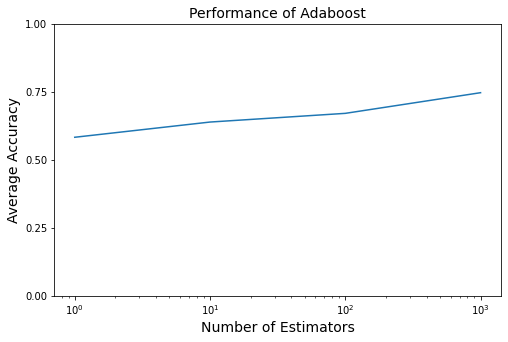

In [37]:
avg_perf = []

avg_perf += [adaboost(1)]
avg_perf += [adaboost(10)]
avg_perf += [adaboost(100)]
avg_perf += [adaboost(1000)]
plot.figure(figsize = (8,5))

plot.plot([1, 10, 100, 1000], avg_perf)
plot.xscale('log')
plot.yticks([0, 0.25, 0.5, 0.75, 1])
plot.title("Performance of Adaboost", fontsize = 14)
plot.xlabel("Number of Estimators", fontsize = 14)
plot.ylabel("Average Accuracy", fontsize = 14)

# Improving Performance
In order to improve the performance to an accuracy above 70%, we decided to use a CNN model and the hyperopt module to find the best hyperparameter combinations (i.e., kernel size, stride, dropout probability, number of convolutional and max pooling layers, and activation function) with three dense layers that achieve the best accuracy by cross-validating the training data.

We downsized the images to a size of 100x100 and evaluated the model 10 times with different hyperparameter combinations. The best accuracy achieved was when the activation fuction in the layers was ReLU, convolutional kernel size was 3, convolutional stride was 1, dropout probability was 0.22 and using 2 convolutional layers and 1 max pooling layer with an accuracy of 92.4%.

In [43]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')


#Reference link for cross-validation with CNN: https://medium.com/@navmcgill/k-fold-cross-validation-in-keras-convolutional-neural-networks-835bed559d04
def optimize_cnn(hyperparameter):
  
  layers = [Conv2D(32, kernel_size=hyperparameter['conv_kernel_size'], strides = hyperparameter['conv_stride'], activation=hyperparameter['activation'], input_shape=(100,100,3)), 
            Conv2D(32, kernel_size=hyperparameter['conv_kernel_size'], strides = hyperparameter['conv_stride'], activation=hyperparameter['activation']), 
            MaxPooling2D(pool_size=(2,2),padding='same'), Dropout(hyperparameter['dropout_prob']),
            Conv2D(64, kernel_size=hyperparameter['conv_kernel_size'], strides = hyperparameter['conv_stride'], activation=hyperparameter['activation']),
            Conv2D(64, kernel_size=hyperparameter['conv_kernel_size'], strides = hyperparameter['conv_stride'], activation=hyperparameter['activation']), 
            MaxPooling2D(pool_size=(2,2),padding='same'), Dropout(hyperparameter['dropout_prob']),
            Conv2D(32, kernel_size=hyperparameter['conv_kernel_size'], strides = hyperparameter['conv_stride'], activation=hyperparameter['activation']),
            Conv2D(32, kernel_size=hyperparameter['conv_kernel_size'], strides = hyperparameter['conv_stride'], activation=hyperparameter['activation']),
            MaxPooling2D(pool_size=(2,2),padding='same'), Dropout(hyperparameter['dropout_prob']),
            Flatten(),
            Dense(512,activation='relu'), #dense layer 1
            Dense(256,activation='relu'), #dense layer 2
            Dense(2,activation='softmax'), #dense layer 3
            ] 

  # Define model using hyperparameters 
  used_layers = [layers[i] for i in hyperparameter['layer_ids']]+layers[12:]
  cnn_model = Sequential(used_layers)
  #print(cnn_model.summary())
  cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  
  v_scores = []
  t_scores = []
  start_time = time.time()
  for i in range(5):
    # tqdm_callback = tfa.callbacks.TQDMProgressBar()
    X_train_fold, X_val_fold, y_train_fold, y_val_fold = train_test_split(X_train_cnn, y_train, test_size=0.20, random_state = np.random.randint(1,1000, 1)[0])
    results = cnn_model.fit(X_train_fold, to_categorical(y_train_fold), validation_data=(X_val_fold, to_categorical(y_val_fold)), epochs=30, batch_size=52, verbose=0)
    t_performance = results.history['accuracy'][-1]
    _, v_performance = cnn_model.evaluate(X_val_fold, to_categorical(y_val_fold), verbose = 0)
    v_scores.append(v_performance)
    t_scores.append(t_performance)
  end_time = time.time()
  print("Training accuracy: {}\nTraining time: {}".format(sum(t_scores)/len(t_scores), end_time-start_time))

  # Evaluate accuracy on validation data
  #performance = cnn_model.evaluate(fnn_val_proc, to_categorical(val_labels), verbose=0)
  averagePerformance = sum(v_scores)/len(v_scores)
  print("Hyperparameters: ", hyperparameter, "Validation Accuracy: ", averagePerformance)
  print("----------------------------------------------------")
  # We want to minimize loss i.e. negative of accuracy
  return({"status": STATUS_OK, "loss": -1*averagePerformance, "model":cnn_model,"params":hyperparameter,"acc":averagePerformance})

# Define search space for hyper-parameters
space = {
    'layer_ids': hp.choice('layer_ids',[[0,2,3,4,6,7],[0,1,2,3],[0,2,3,8,10,11],[0,2,3]]),
    'conv_kernel_size': hp.choice('conv_kernel_size',[1,3,5]),
    'conv_stride': hp.choice('conv_stride',[1,2]),
    'activation': hp.choice('activation', ['relu','selu','tanh']),
    'dropout_prob': hp.uniform('dropout_prob',0,0.35),
}

trials = Trials()
with tf.device('/device:GPU:0'):
  # Find the best hyperparameters
  best = fmin(
          optimize_cnn,
          space,
          algo=tpe.suggest,
          trials=trials,
          max_evals=10,
          verbose=0,
          show_progressbar=False
      )
  
  test_result = trials.results[np.argmin([r['loss'] for r in trials.results])] #best trial info
  best_model = test_result['model']
  best_params = test_result['params']
  best_acc = test_result['acc']

  print("\n==================================\n")
  print("Best Hyperparameters:", best_params) #the output here doesn't makes sense because it prints indices into the hp.choice objects
  print("Accuracy:", best_acc)

Training accuracy: 0.9580000042915344
Training time: 12.796416759490967
Hyperparameters: 
{'activation': 'tanh', 'conv_kernel_size': 3, 'conv_stride': 2, 'dropout_prob': 0.26295954043167724, 'layer_ids': (0, 2, 3, 4, 6, 7)}
Validation Accuracy: 
0.8519999980926514
----------------------------------------------------
Training accuracy: 0.9329999923706055
Training time: 13.141404628753662
Hyperparameters: 
{'activation': 'relu', 'conv_kernel_size': 5, 'conv_stride': 2, 'dropout_prob': 0.1171665923430434, 'layer_ids': (0, 2, 3, 4, 6, 7)}
Validation Accuracy: 
0.871999990940094
----------------------------------------------------
Training accuracy: 0.9690000057220459
Training time: 18.41886019706726
Hyperparameters: 
{'activation': 'tanh', 'conv_kernel_size': 5, 'conv_stride': 1, 'dropout_prob': 0.11396514384320573, 'layer_ids': (0, 2, 3, 8, 10, 11)}
Validation Accuracy: 
0.8399999856948852
----------------------------------------------------
Training accuracy: 0.947000014781952
Training t

# Bonus (Test Accuracy)
While we improve the performance by more than 20% using a CNN model, we did not consider the following:



1.   Normalizing the training dataset.
2.   Using a binary classificator instead of a categorical classificator.
3.   Making more than 10 evaluations in a single run.

We did consider those three things for the bonus part.




## Normalization of datasets
The function below gets the images filenames from the dataset given and return all of them in a numpy array. This is used for the testing dataset since we need them to create the csv file with the predictions.

In [ ]:
#Gets image filenames (used for the testing dataset)
def get_imgs_names(dataframe): 
  filenames = dataframe['filename']
  return filenames.to_numpy()

We load the datasets and normalize the data using Standard Scaler, which fits the training dataset and transforms it. Then, it uses the same parameters to normalize (i.e., transforms) the testing dataset.

In [ ]:
#loads the datasets and normalizes it
#ref: https://datascience.stackexchange.com/questions/27615/should-we-apply-normalization-to-test-data-as-well
scaler = StandardScaler()

X_train = get_imgs(train_data, train_dir_cnn)
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)

X_test = get_imgs(test_data, test_dir_cnn)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
X_test_filenames = get_imgs_names(test_data)

## Changes to the CNN model for more accurate decisions on the test dataset
We used the same CNN model with the following changes:

1. Normalize data (as explained above).
2. Change the model from multi-class classification to binary classification since this is a binary classification task. In other words, the last dense layer uses sigmoid activation function instead of softmax and loss is changed to binary_crossentropy.

We evaluated the model 40 times using hyperopt in more than three runs to find the best two accuracy scores (i.e., best models) using cross-validation on the training dataset.

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

#Reference link for cross-validation with CNN: https://medium.com/@navmcgill/k-fold-cross-validation-in-keras-convolutional-neural-networks-835bed559d04
def optimize_cnn(hyperparameter):
  
  layers = [Conv2D(32, kernel_size=hyperparameter['conv_kernel_size'], strides = hyperparameter['conv_stride'], activation=hyperparameter['activation'], input_shape=(100,100,3)), 
            Conv2D(32, kernel_size=hyperparameter['conv_kernel_size'], strides = hyperparameter['conv_stride'], activation=hyperparameter['activation']), 
            MaxPooling2D(pool_size=(2,2),padding='same'), Dropout(hyperparameter['dropout_prob']),
            Conv2D(64, kernel_size=hyperparameter['conv_kernel_size'], strides = hyperparameter['conv_stride'], activation=hyperparameter['activation']),
            Conv2D(64, kernel_size=hyperparameter['conv_kernel_size'], strides = hyperparameter['conv_stride'], activation=hyperparameter['activation']), 
            MaxPooling2D(pool_size=(2,2),padding='same'), Dropout(hyperparameter['dropout_prob']),
            Conv2D(32, kernel_size=hyperparameter['conv_kernel_size'], strides = hyperparameter['conv_stride'], activation=hyperparameter['activation']),
            Conv2D(32, kernel_size=hyperparameter['conv_kernel_size'], strides = hyperparameter['conv_stride'], activation=hyperparameter['activation']),
            MaxPooling2D(pool_size=(2,2),padding='same'), Dropout(hyperparameter['dropout_prob']),
            Flatten(),
            Dense(512,activation='relu'), #dense layer 1
            Dense(256,activation='relu'), #dense layer 2
            Dense(1,activation='sigmoid'), #dense layer 3
            ] 

  # Define model using hyperparameters 
  used_layers = [layers[i] for i in hyperparameter['layer_ids']]+layers[12:]
  cnn_model = Sequential(used_layers)
  cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  
  v_scores = []
  t_scores = []
  start_time = time.time()
  for i in range(5):
    # tqdm_callback = tfa.callbacks.TQDMProgressBar()
    X_train_fold, X_val_fold, y_train_fold, y_val_fold = train_test_split(X_train, y_train, test_size=0.20, random_state = np.random.randint(1,1000, 1)[0])
    results = cnn_model.fit(X_train_fold, y_train_fold, validation_data=(X_val_fold, y_val_fold), epochs=30, batch_size=52, verbose=0)
    t_performance = results.history['accuracy'][-1]
    _, v_performance = cnn_model.evaluate(X_val_fold, y_val_fold, verbose = 0)
    v_scores.append(v_performance)
    t_scores.append(t_performance)
  end_time = time.time()
  print("Training accuracy: {}\nTraining time: {}".format(sum(t_scores)/len(t_scores), end_time-start_time))

  averagePerformance = sum(v_scores)/len(v_scores)
  print("Hyperparameters: ", hyperparameter, "Validation Accuracy: ", averagePerformance)
  print("----------------------------------------------------")
  # We want to minimize loss i.e. negative of accuracy
  return({"status": STATUS_OK, "loss": -1*averagePerformance, "model":cnn_model,"params":hyperparameter,"acc":averagePerformance})

# Define search space for hyper-parameters
space = {
    'layer_ids': hp.choice('layer_ids',[[0,2,3,4,6,7],[0,1,2,3],[0,2,3,8,10,11],[0,2,3]]),
    'conv_kernel_size': hp.choice('conv_kernel_size',[1,3,5]),
    'conv_stride': hp.choice('conv_stride',[1,2]),
    'activation': hp.choice('activation', ['relu','selu','tanh']),
    'dropout_prob': hp.uniform('dropout_prob',0,0.35),
}

trials = Trials()
with tf.device('/device:GPU:0'):
  # Find the best hyperparameters
  best = fmin(
          optimize_cnn,
          space,
          algo=tpe.suggest,
          trials=trials,
          max_evals=40,
          verbose=0,
          show_progressbar=False
      )

## Best two models
We get the best two results and predict classes on the testing dataset using the best two models.

In [ ]:
#sort by loss value
trials_sorted = sorted(trials.results, key = lambda i: i['loss'])

#get top 2 models
f_best_model = trials_sorted[0]['model']
s_best_model = trials_sorted[1]['model']

#print results with hyperparameters
print("First best validation accuracy:", trials_sorted[0]['acc'], "with hyperparameters:", trials_sorted[0]['params'])
print("Second best validation accuracy:", trials_sorted[1]['acc'], "with hyperparameters:", trials_sorted[1]['params'])

#predictions to be written to csv file
f_predictions = f_best_model.predict_classes(X_test)
s_predictions = s_best_model.predict_classes(X_test)

We save the predictions on testing dataset using the best two models in a csv file.

In [ ]:
file = 'bonus_v2.csv'

with open(basePath+"/"+file, 'w', newline='') as csvfile:
    fieldnames = ['filename', 'model_1', 'model_2']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

    for i in range(len(f_predictions)):
      writer.writerow({'filename': X_test_filenames[i], 'model_1': f_predictions[i][0], 'model_2': s_predictions[i][0]})

In multiple runs, we got better models, so we decided to get the best two runs (i.e., 4 decisions in total) and merge the best two decisions (according to the cross-validation accuracy) across both files into a single csv file called "bonus_final.csv".

The best two models are the following:

Best Model 1:
* Validation accuracy: 96.40%
* Hyperparameters:
    1. Activation function: ReLu
    2. Kernel size: 3
    3. Stride: 2
    4. Dropout: 0.2610
    5. Convolutional layers: 1 
    6. Max pooling layers: 1

Best Model 2:
* Validation accuracy: 96% 
* Hyperparameters:
  1. Activation function: SeLu
  2. Kernel size: 3
  3. Stride: 1
  4. Dropout: 0.0537
  5. Convolutional layers: 2
  6. Max pooling layers: 1

In [28]:
file1 = 'bonus_v2.csv'
file2 = 'bonus.csv'

reader1 = csv.DictReader(open(basePath+"/"+file1))
reader2 = csv.DictReader(open(basePath+"/"+file2))
model1 = []
model2 = []
for row in reader1:
  model1.append(row['model_1'])

for row in reader2:
  model2.append(row['model_1'])

fieldnames = ['filename', 'model_1', 'model_2']

writer = csv.DictWriter(open(basePath+"/"+'bonus_final.csv','w',newline=''),fieldnames=fieldnames)
writer.writeheader()

for i in range(len(f_predictions)):
  writer.writerow({'filename': X_test_filenames[i], 'model_1': model1[i], 'model_2': model2[i]})

# Reporting Other Teams' Work

## Preprocessing

| Team | Preprocessing size |
|-|-|
| 1 | 64x64 |
| 3 | 224x224* |
| 5 | 224x224* |
| 7 | ? |
| 9 | 400x400 |
| 11 | 200x200 |
| 13 | 128x128 (64x64 for AdaBoost) |
| 15 | Original image size |

*224x224 is the VGG input size

## Extracted Features

| Team | Src img | Gabor | Edges | HOG | Other |
|-|-|-|-|-|-|
| 1 | gray | ✓ | ✓ | ✓ | Mean pixel value |
| 3 |  | x16 | ✓ | ✓ | SURF |
| 5 |  |  |  |  | VGG19 output from src images |
| 7 | ✓ | ✓ | ✓ | ✓ | Age, gender, location; xrv (pretrained xray-parsing neural network, 18-dimensional output); mean pixel value |
| 9 |  | ✓ |  | ✓ | SIFT, SURF |
| 11 |  |  |  | ✓ |  |
| 13 |  | ✓ |  | ✓ | Computer vision toolbox |
| 15 | gray |  | ✓ | ✓ | Mean pixel value |

## Feature Exploration

| Team | Feature Scoring systems |
|-|-|
| 1 | Fisher's score, gini index and conditional entropy |
| 3 | fisher score |
| 5 | ? |
| 7 | fisher score |
| 9 | ? |
| 11 | ? |
| 13 |  - |
| 15 |  - |

## Feature Selection

| Team | Filter | Wrapper | Dimensionality Reduction | Base Estimator |
|-|-|-|-|-|
| 1 | Fisher’s score, correlation coefficient | RFE, SFS | PCA, kPCA and LDA | SVM |
| 3 | SelectKBest | RFE | None | SVM |
| 5 | ? |  | None | logistic regression |
| 7 | Fisher’s score | ? | None | linear SVM |
| 9 | 𝝌² test | PCA | None | SVM |
| 11 | ? | RFE | None | logistic regression |
| 13 | ✓ | ✓ |  | random forest |
| 15 | Manual information | RFE | PCA |  |

### Feature Selection Performance

| Team | Filter | Wrapper | AdaBoost |
|-|-|-|-|
| 1 | 51.2% | 52.8% (logistic regression) | 50.8% |
| 3 | 79.2% | 82% (linear regression) | 64% (w/ filter: 88%) (w/ wrapper: 77%) |
| 5 | 85% |  |  |
| 7 | 82.4% | ? | ? |
| 9 | 62% | 64% | ? |
| 11 | 72% | 82% | 69.8% (63.2% on other inputs) |
| 13 | 74% | 77.5% | 74.7% |
| 15 | 66.8% | 76% | 76% |

## Improving Performance

| Team | Base Model | Hyperparameters | Accuracy |
|-|-|-|-|
| 1 | RESNET18 | batch size, learning rate, learning rate decay, weight decay (hyperopt) | 72% |
| 3 | VGG-19 | number of selected features, feature selection | 91.9% (filter), 92.4% (wrapper) |
| 5 | ? |  |  |
| 7 | VGG16 | Inherited from pretrained model | 75% |
| 9 | None | Not stated; no rigorous tuning method; used a two-layer CNN with 50% dropout | 72% |
| 11 | None* |  |  |
| 13 | VGG16 | Inherited from pretrained model | 72.1% |
| 15 | None (CNN) | Number of convolutional layers (3), number of dense layers (3), activation function (ReLU), optimizer (sgd) | 91.6% |

*Team 11 proposed to use a CNN as “future work”

## Additional Information

Team 7
* age feature discretized into 4 equal-sized ranges and one-hot encoded
* location feature one-hot encoded
  * was one of the most discriminative features
* randomly rotated images -15 to +15 degrees to vary the dataset
* ADAM optimizer, learning rate 0.00001
* reached 58% accuracy with LeNet before using VGG

Team 15
* noted that they may consider flipping the training images to train the model more extensively
* concluded that ensemble learning is slow, and that because they took x-ray images straight in and spent a lot of time training the models, it led to extremely accurate results


